In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import joblib


In [20]:
df = pd.read_csv('../data/parkinsons.csv')
df.head(6)

name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   
5  phon_R01_S01_6      120.552       131.162       113.787         0.00968   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   
5           0.00008   0.00463   0.00750     0.01388       0.04701  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.06545  0.02211  21.033       1  0.414783  0.815285 -4.813031   
1      0.09403  0.01929  19.085       1  0.458359  0.819521 -4.075192   
2      0.08270  0.01309  20.651       1  0.429895  0.825288 -4.443179   
3      0.08771  0.01353  20.644       1  0.434969  0.819235 -4.117501   
4      0.10470  0.01767  19.649       1  0.417356  0.823484 -3.747787   
5      0.06985  0.01222  21.378       1  0.415564  0.825069 -4.242867   

    spread2        D2       PPE  
0  0.266482  2.301442  0.284654  
1  0.335590  2.486855  0.368674  
2  0.311173  2.342259  0.332634  
3  0.334147  2.405554  0.368975  
4  0.234513  2.332180  0.410335  
5  0.299111  2.187560  0.357775  

[6 rows x 24 columns]

In [21]:
y = df['status']
y.unique()

array([1, 0], dtype=int64)

In [22]:
X = df.drop(['status','name'],axis = 1)

In [23]:
X.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')

In [24]:
def get_pearson_corr_matrix(df: pd.DataFrame) -> pd.DataFrame:
    ### BEGIN SOLUTION
    return df.corr(method="pearson")
    ### END SOLUTION

In [25]:
# Tạo correlation matrix từ hàm đã viết
corr_matrix = get_pearson_corr_matrix(X)

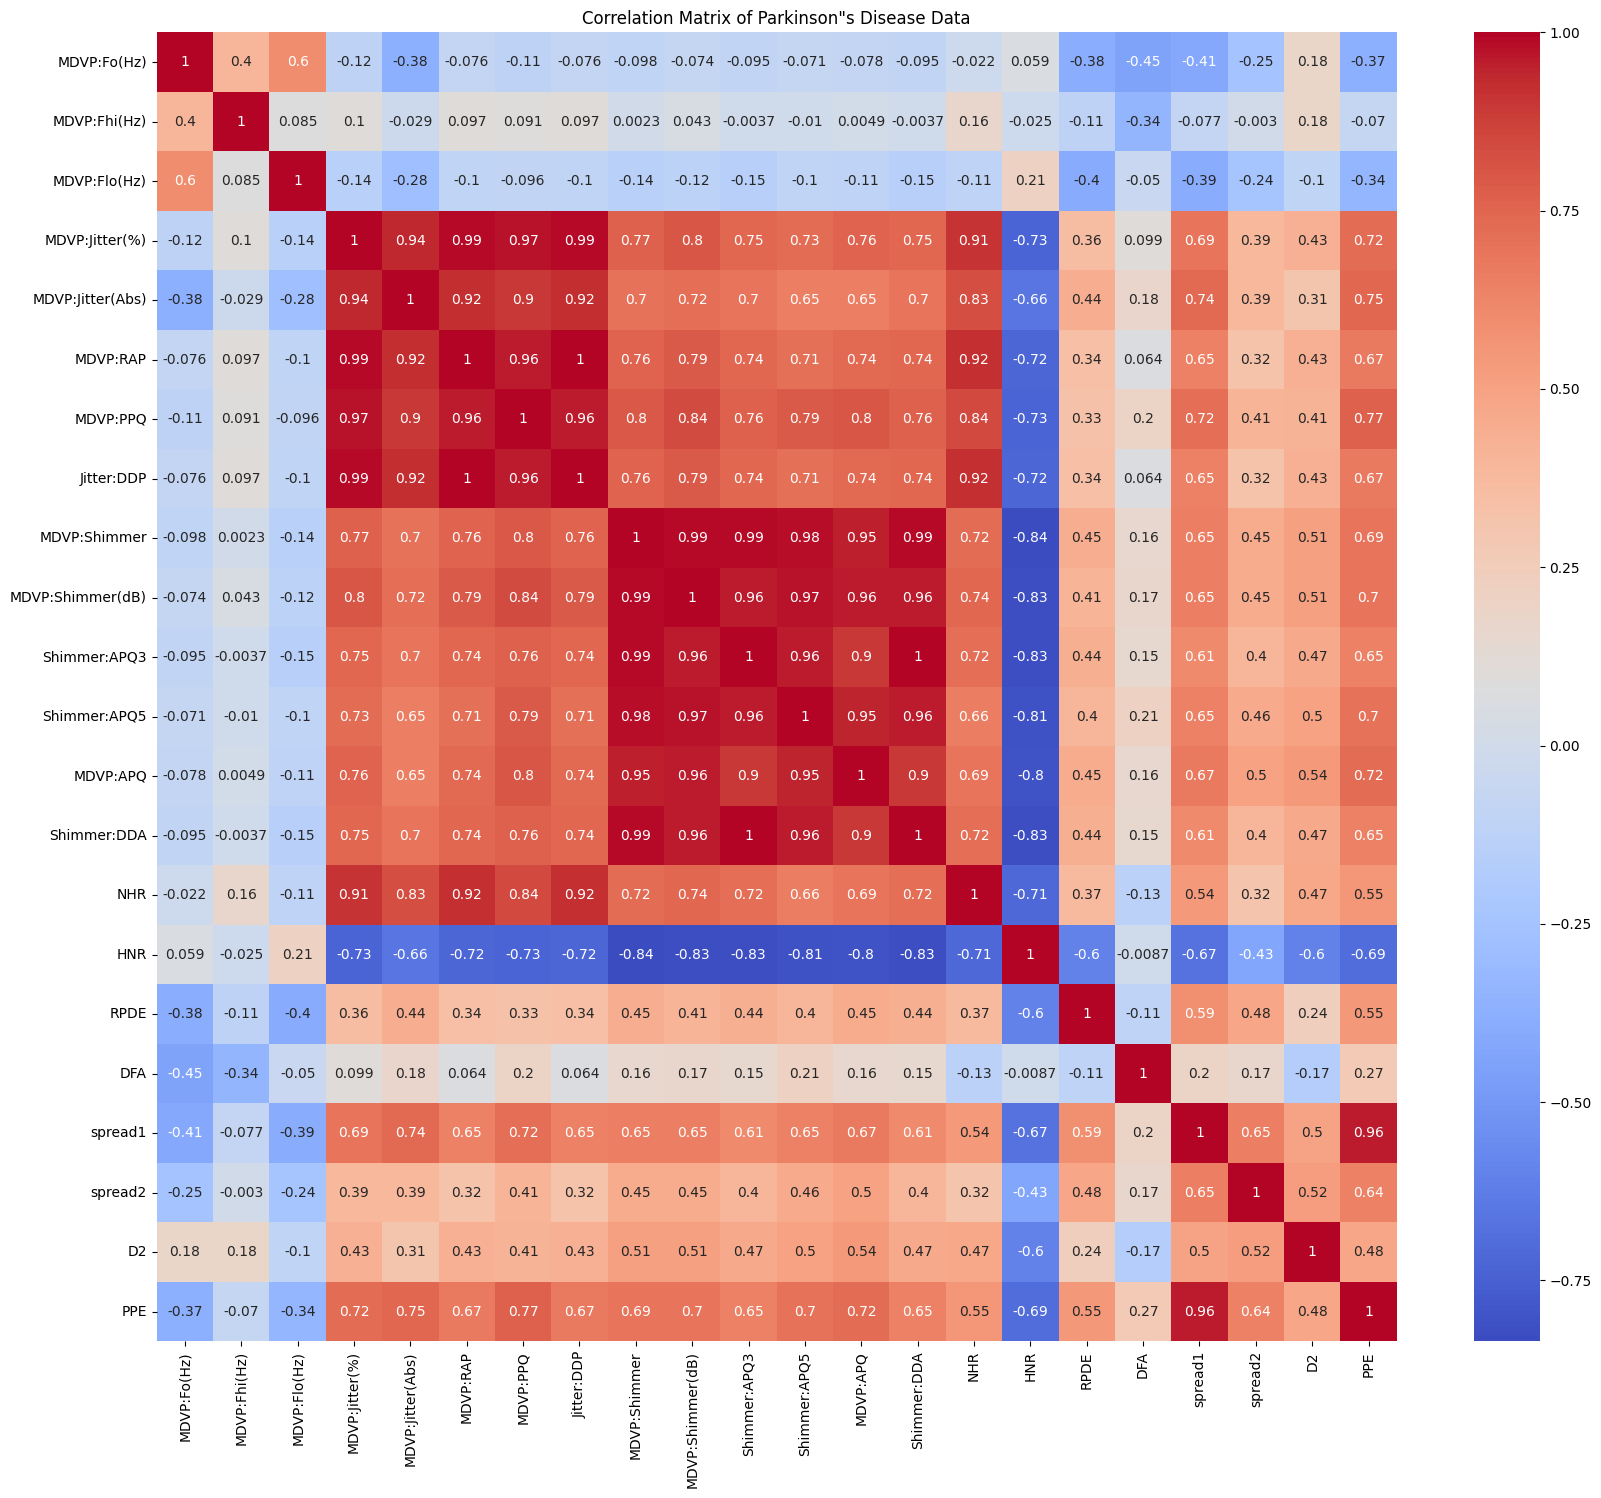

In [26]:
# Plot the correlation matrix
plt.figure(figsize=(20,17))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Parkinson"s Disease Data')
plt.show()

In [27]:
def drop_highly_correlated_features(df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    ### BEGIN SOLUTION
    target_col = "status" if "status" in df.columns else None
    feature_cols = [col for col in df.columns if col != target_col]
    
    corr_matrix = df[feature_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    retained_cols = [col for col in df.columns if col not in to_drop]
    return df[retained_cols]
    ### END SOLUTION

In [28]:
# Khởi tạo giá trị correlation_threshold là 0.7
correlation_threshold = 0.7
# Tiến hành loại bỏ những đặc trưng
X = drop_highly_correlated_features(X, correlation_threshold)

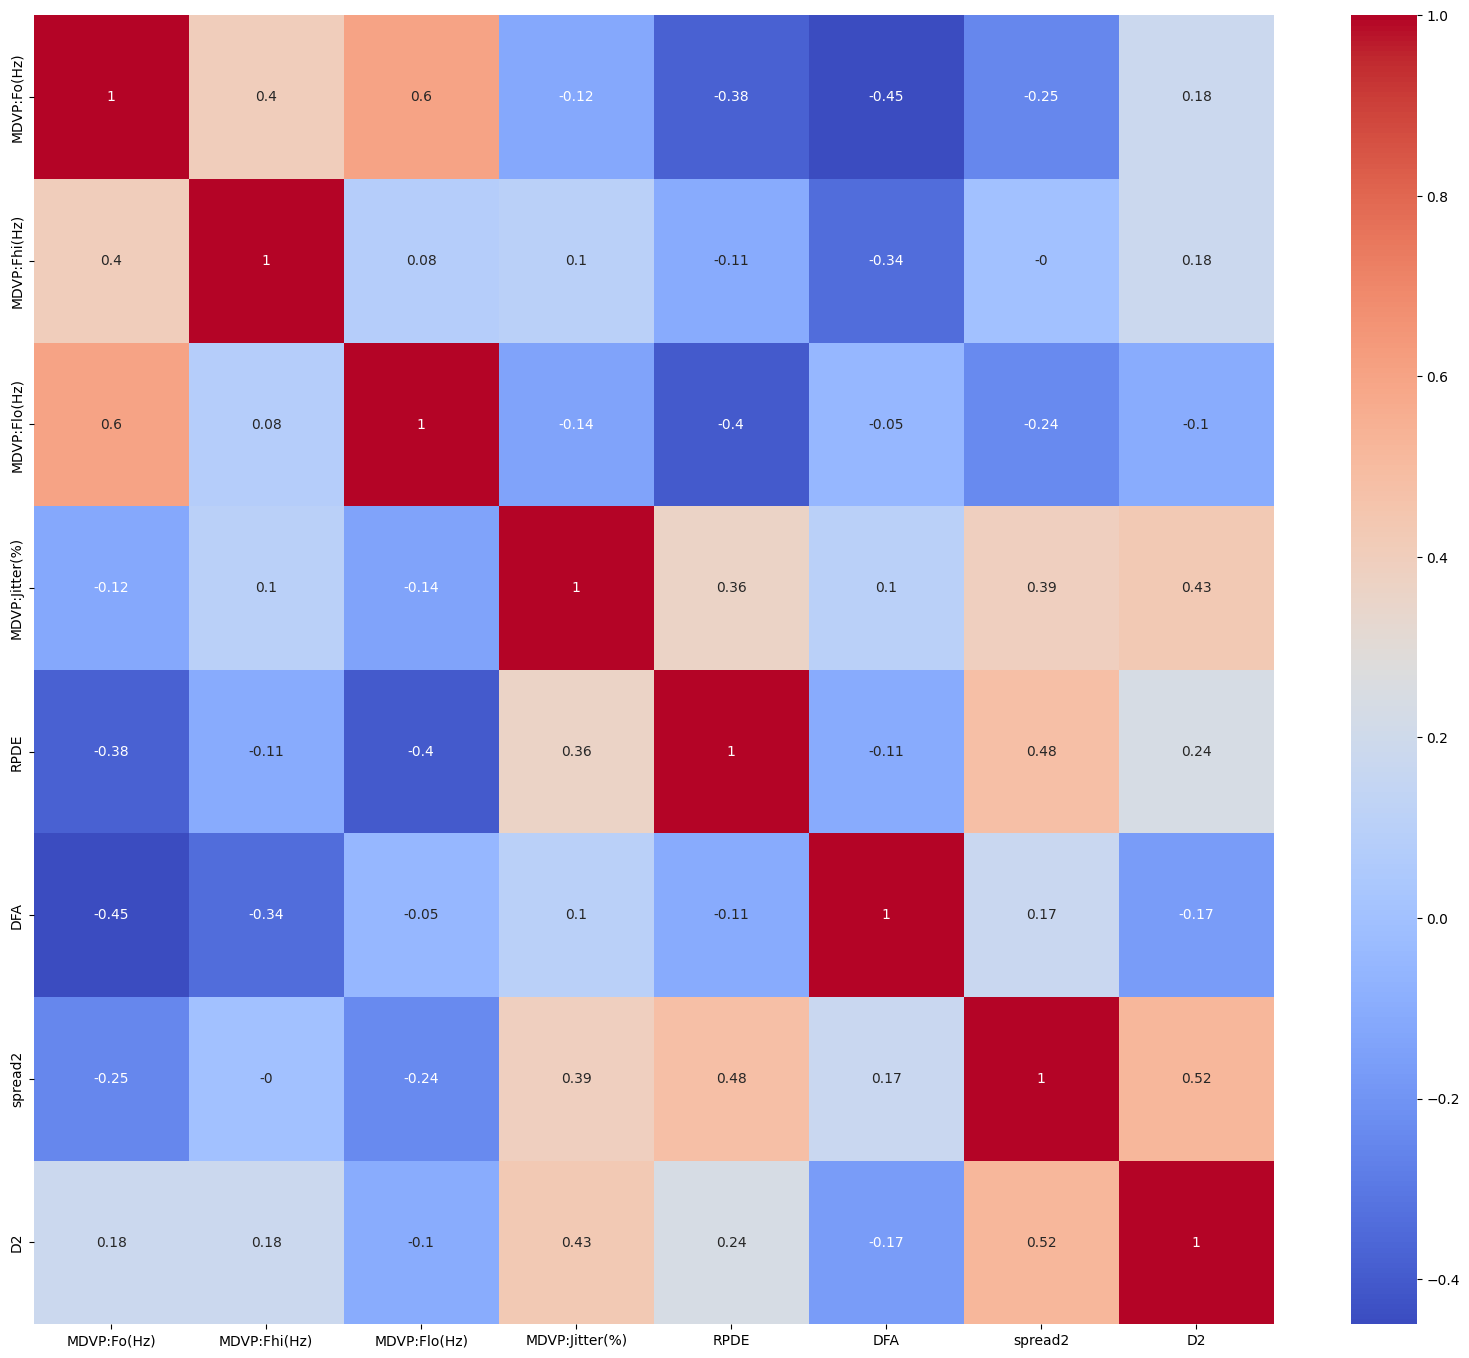

In [29]:
corr_matrix = get_pearson_corr_matrix(X)
plt.figure(figsize=(20,17))
sns.heatmap(corr_matrix.round(2), annot=True, cmap='coolwarm')
plt.show()

In [30]:
print(X.columns)
print(len(X.columns))

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'RPDE',
       'DFA', 'spread2', 'D2'],
      dtype='object')
8


In [31]:
X.to_csv('../frontend/public/dap.csv',index=False)

In [32]:
df = pd.concat([X, y], axis=1)

# Lưu thành file CSV
df.to_csv("dap.csv", index=False)


In [33]:
df = pd.read_csv('dap.csv')
X = df.drop(['status'],axis = 1)
y = df['status']
scaler = StandardScaler()
X = scaler.fit_transform(X)

joblib.dump(scaler,'./model/scaler.pkl')
print('\nScaler saved successfully!')



Scaler saved successfully!


In [35]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23520945)

In [36]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')
print(classification_report(y_test, y_pred))

Accuracy: 89.74%
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.89      0.96      0.93        26

    accuracy                           0.90        39
   macro avg       0.90      0.87      0.88        39
weighted avg       0.90      0.90      0.90        39



c:\Users\Admin\anaconda3\envs\GPU\lib\site-packages\xgboost\core.py:158: UserWarning: [20:53:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [37]:
import joblib

# Save the trained model
joblib.dump(model, './model/parkinsons_xgboost_model.pkl')

['./model/parkinsons_xgboost_model.pkl']

In [38]:
# Load the model
model = joblib.load('./model/parkinsons_xgboost_model.pkl')
test_size = round(len(y_test)/1)
# Predict on new data
new_pred = model.predict(X_test[:test_size])
print(f'Predictions: {new_pred}')
a = 0
for i in range(len(new_pred)):
    if (new_pred[i] == y[i]):
        # print(f'Prediction {i+1} is correct')
        a+=1
print(f'keke {a} and {test_size} and acc is {a/test_size}')

Predictions: [1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1
 1 0]
keke 28 and 39 and acc is 0.717948717948718


tìm thông số tối ưu nè

In [ ]:
from sklearn.model_selection import GridSearchCV

# Định nghĩa các tham số cần tìm kiếm
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Tạo model với GPU
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    tree_method='gpu_hist',  # Sử dụng GPU
    gpu_id=0  # Chỉ định GPU ID nếu có nhiều GPU
)

# Tạo GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,  # số fold cross-validation
    scoring='accuracy',  # đánh giá dựa trên accuracy
    n_jobs= -1,
    verbose=1
)

# Fit model
grid_search.fit(X_train, y_train)

# Hiển thị tham số tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Sử dụng mô hình tốt nhất để dự đoán
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 3 folds for each of 3888 candidates, totalling 11664 fits


c:\Users\Admin\anaconda3\envs\GPU\lib\site-packages\xgboost\core.py:158: UserWarning: [20:59:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\anaconda3\envs\GPU\lib\site-packages\xgboost\core.py:158: UserWarning: [20:59:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\anaconda3\envs\GPU\lib\site-packages\xgboost\core.py:158: UserWarning: [20:59:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\a

Best parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Best score: 0.923076923076923


c:\Users\Admin\anaconda3\envs\GPU\lib\site-packages\xgboost\core.py:158: UserWarning: [21:07:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\anaconda3\envs\GPU\lib\site-packages\xgboost\core.py:158: UserWarning: [21:07:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\anaconda3\envs\GPU\lib\site-packages\xgboost\core.py:158: UserWarning: [21:07:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [44]:
import joblib

# Save the trained model
joblib.dump(best_model, './model/best_model_w_grid.pkl')

['./model/best_model_w_grid.pkl']

In [42]:
y_pred

array([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0])

In [43]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')
print(classification_report(y_test, y_pred))

Accuracy: 92.31%
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.90      1.00      0.95        26

    accuracy                           0.92        39
   macro avg       0.95      0.88      0.91        39
weighted avg       0.93      0.92      0.92        39



In [45]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Định nghĩa phạm vi tham số cần tìm kiếm
param_dist = {
    'n_estimators': np.arange(50, 500, 50),
    'learning_rate': np.logspace(-3, 0, 10),
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 6),
    'gamma': np.linspace(0, 0.5, 10),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5)
}

# Tạo model cơ bản
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

# Tạo RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # số lần thử ngẫu nhiên
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=23520945
)

# Fit model
random_search.fit(X_train, y_train)

# Hiển thị tham số tốt nhất
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Sử dụng mô hình tốt nhất
best_model2 = random_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 450, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.021544346900318832, 'gamma': 0.1111111111111111, 'colsample_bytree': 0.6}
Best score: 0.923076923076923


In [46]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')
print(classification_report(y_test, y_pred))

Accuracy: 89.74%
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.89      0.96      0.93        26

    accuracy                           0.90        39
   macro avg       0.90      0.87      0.88        39
weighted avg       0.90      0.90      0.90        39



In [47]:
import joblib

# Save the trained model
joblib.dump(best_model2, './model/model_ran_ser.pkl')

['./model/model_ran_ser.pkl']

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Định nghĩa phạm vi tham số cần tìm kiếm
param_dist = {
    'n_estimators': np.arange(50, 500, 50),
    'learning_rate': np.logspace(-3, 0, 10),
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 6),
    'gamma': np.linspace(0, 0.5, 10),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5)
}

# Tạo model với GPU
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    tree_method='gpu_hist',  # Sử dụng GPU
    gpu_id=0  # Chỉ định GPU ID nếu có nhiều GPU
)

# Tạo RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # số lần thử ngẫu nhiên
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=23520945
)

# Fit model
random_search.fit(X_train, y_train)

# Hiển thị tham số tốt nhất
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Sử dụng mô hình tốt nhất
best_model2 = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')
print(classification_report(y_test, y_pred))